## Load Libraries

In [23]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import ndcg_score
import os
import logging
from fuxictr.utils import load_config, set_logger, print_to_json
from fuxictr.features import FeatureMap
from fuxictr.pytorch.torch_utils import seed_everything
from fuxictr.pytorch.dataloaders import H5DataLoader
from fuxictr.preprocess import FeatureProcessor, build_dataset
import src
import gc
import os
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [24]:
books_df = pd.read_csv('data/book/Books.csv')
users_df = pd.read_csv('data/book/Users.csv')
ratings_df = pd.read_csv('data/book/Ratings.csv')

df = pd.merge(users_df, ratings_df, on='User-ID', how='left')
df = pd.merge(df, books_df, on='ISBN', how='left')

df.head()

/Users/rafael/miniconda3/envs/recsys/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,User-ID,Location,Age,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,1,"nyc, new york, usa",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,"stockton, california, usa",18.0,0195153448,0.0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
2,3,"moscow, yukon territory, russia",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,"porto, v.n.gaia, portugal",17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,"farnborough, hants, united kingdom",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Exploratory Data Analysis

1. Remove observations where the user did not read the book

In [25]:
df = df[df['Book-Rating'].notnull()]

2. Check missing values
 - Replace Book-Author and Publisher with `unknown`

In [26]:
df.columns[df.isna().any()].tolist()

['Age',
 'Book-Title',
 'Book-Author',
 'Year-Of-Publication',
 'Publisher',
 'Image-URL-S',
 'Image-URL-M',
 'Image-URL-L']

In [27]:
df['Book-Author'] = df['Book-Author'].fillna('unknown')
df['Publisher'] = df['Publisher'].fillna('unknown')

3. Remove observations with missing information about the book

In [28]:
df = df[df['Book-Title'].notnull()]

4. Replace non integer Years with Nans

In [29]:
df['Year-Of-Publication'] = pd.to_numeric(df['Year-Of-Publication'], errors='coerce')

5. Check Age, Year-Of-Publication and Book-Rating distribution

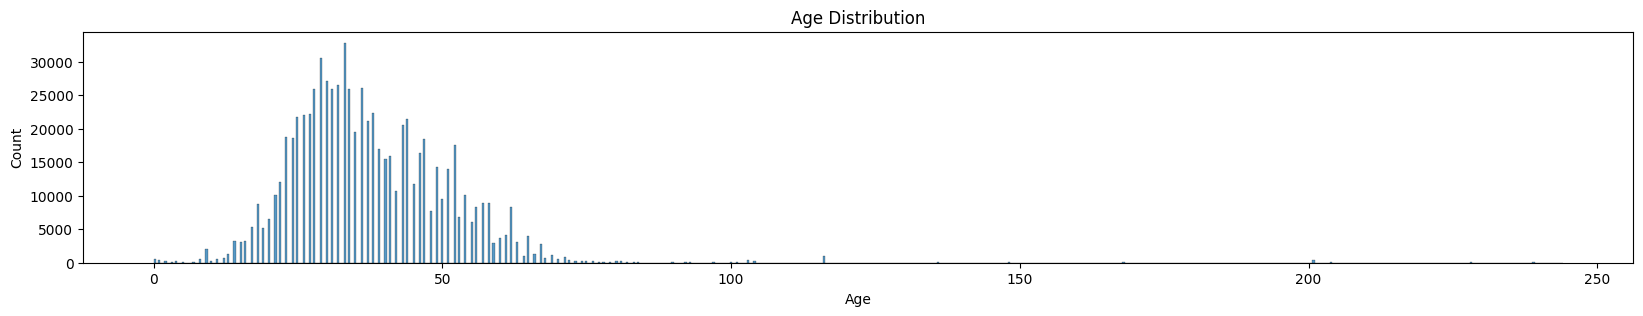

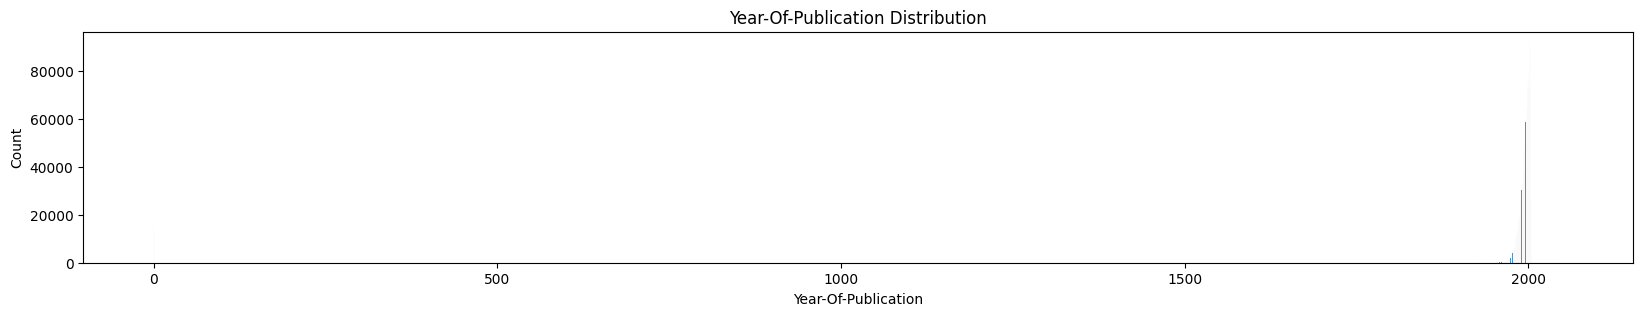

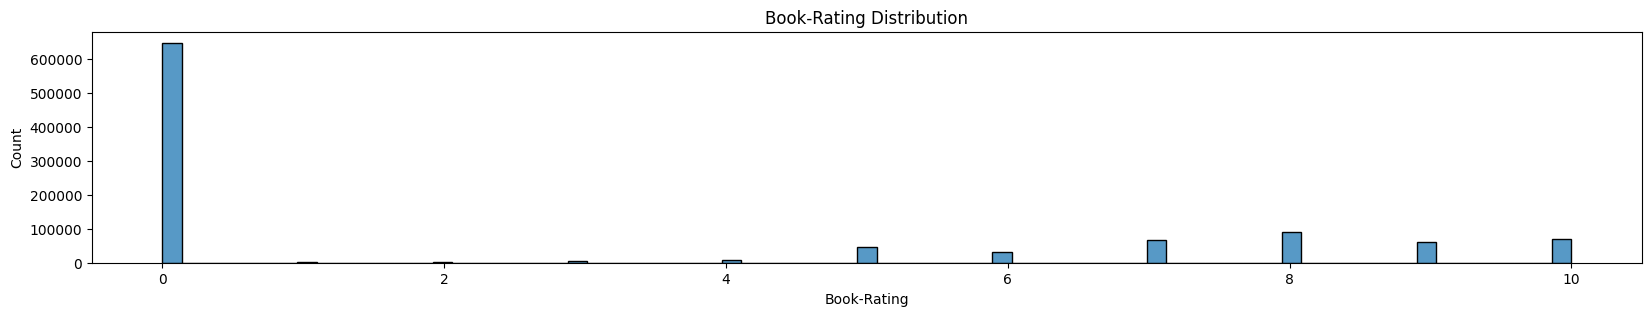

In [30]:
plt.rcParams["figure.figsize"] = (20,3)
sns.histplot(data=df, x='Age')
plt.title('Age Distribution')
plt.show()

sns.histplot(data=df, x='Year-Of-Publication')
plt.title('Year-Of-Publication Distribution')
plt.show()

sns.histplot(data=df, x='Book-Rating')
plt.title('Book-Rating Distribution')
plt.show()


6. Clean up data:
    - Replace Ages with values higher than 100 (which seems an error) with Nans
    - Set the maximum possible year to 2021 and replace Year-of-Publication <= 0 with Nans
    - Remove Observations with Rating = 0, since those where books read by the user but they did not rated them
    - Create 3 features (city, state, country) from Location
    - Create binary label, let's assume that ratings above 7 are interesting for the customer and below or equal to 7 are not interesting

In [32]:
df['Age'] = np.where(df['Age'] > 100, None, df['Age'])

df['Year-Of-Publication'] = np.where(df['Year-Of-Publication'].clip(0, 2021) <= 0, None, df['Year-Of-Publication'])

df = df[df['Book-Rating'] > 0]

df['city'] = df['Location'].apply(lambda x: x.split(',')[0].strip()) # too noisy, we will not use
df['state'] = df['Location'].apply(lambda x: x.split(',')[1].strip())
df['country'] = df['Location'].apply(lambda x: x.split(',')[2].strip())

df['label'] = (df['Book-Rating'] > 7)*1

## Modeling

### Split Test-Train Data

In [33]:
# create list with unique users
users = df['User-ID'].unique()

# shuffle list
random.seed(42)
random.shuffle(users)

# create list of users to train and to test
train_users = users[:int(0.7*len(users))]
val_users = users[int(0.7*len(users)):int(0.8*len(users))]
test_users = users[int(0.8*len(users)):]

# train and test df
train_df = df[df['User-ID'].isin(train_users)]
val_df = df[df['User-ID'].isin(val_users)]
test_df = df[df['User-ID'].isin(test_users)]

### Pre-Process dataset

1. Convert textual feature `Book-Title` into embedding vector
 - Multilingual model to encode `Book-Title` since it is written in different languages
 - Reduce dimensionality of the embeddings with PCA and 80% of variance explained.
 - Extract distinct `Book-Title` first in order to not bias the dimensionality reduction if a book was read by more users than other

In [ ]:
# create embeddings
train_embeddings = utils.create_embeddings(train_df.copy(), "Book-Title")
val_embeddings = utils.create_embeddings(val_df.copy(), "Book-Title")
test_embeddings = utils.create_embeddings(test_df.copy(), "Book-Title")

# reduce dimensionality with PCA
train_embeddings, pca = utils.reduce_dimensionality(train_embeddings, 0.8)
val_embeddings = pca.transform(val_embeddings)
test_embeddings = pca.transform(test_embeddings)

# join embeddings to dataframes
train_df = utils.add_embeddings_to_df(train_df, train_embeddings, "Book-Title")
val_df = utils.add_embeddings_to_df(val_df, val_embeddings, "Book-Title")
test_df = utils.add_embeddings_to_df(test_df, test_embeddings, "Book-Title")

2. Fill missing values and normalize data

In [41]:
# set numerical columns
NUMERICAL_COLUMNS = [i for i in train_df.columns if "Book-Title_" in i] + ['Age', 'Year-Of-Publication']

# define preprocessing pipeline and transform data
pipe = utils.define_pipeline(NUMERICAL_COLUMNS)
train_df[NUMERICAL_COLUMNS] = pipe.fit_transform(train_df[NUMERICAL_COLUMNS])
val_df[NUMERICAL_COLUMNS] = pipe.transform(val_df[NUMERICAL_COLUMNS])
test_df[NUMERICAL_COLUMNS] = pipe.transform(test_df[NUMERICAL_COLUMNS])

#### Save pre-processed datasets

In [49]:
train_df.to_csv('data/book/train.csv', index=False)
val_df.to_csv('data/book/valid.csv', index=False)
test_df.to_csv('data/book/test.csv', index=False)

### Get model and dataset configurations

In [50]:
experiment_id = 'FinalMLP_book'
params = load_config(f"config/{experiment_id}/", experiment_id)
params['gpu'] = -1
set_logger(params)
logging.info("Params: " + print_to_json(params))
seed_everything(seed=params['seed'])

2024-02-15 11:25:54,430 P7060 INFO Params: {
    "batch_size": "4096",
    "data_format": "csv",
    "data_root": "./data/book/",
    "dataset_id": "FinalMLP_book",
    "debug_mode": "False",
    "early_stop_patience": "2",
    "embedding_dim": "10",
    "embedding_regularizer": "0.01",
    "epochs": "10",
    "eval_steps": "None",
    "feature_cols": "[{'active': True, 'dtype': 'float', 'name': ['Age', 'Book-Title_0', 'Book-Title_1', 'Book-Title_2', 'Book-Title_3', 'Book-Title_4', 'Book-Title_5', 'Book-Title_6', 'Book-Title_7', 'Book-Title_8', 'Book-Title_9', 'Book-Title_10', 'Book-Title_11', 'Book-Title_12', 'Book-Title_13', 'Book-Title_14', 'Book-Title_15', 'Book-Title_16', 'Book-Title_17', 'Book-Title_18', 'Book-Title_19', 'Book-Title_20', 'Book-Title_21', 'Book-Title_22', 'Book-Title_23', 'Book-Title_24', 'Book-Title_25', 'Book-Title_26', 'Book-Title_27', 'Book-Title_28', 'Book-Title_29', 'Book-Title_30', 'Book-Title_31', 'Book-Title_32', 'Book-Title_33', 'Book-Title_34', 'Book-Ti

### Create Feature Mapping and convert data into h5 format

In [51]:
data_dir = os.path.join(params['data_root'], params['dataset_id'])
feature_map_json = os.path.join(data_dir, "feature_map.json")
if params["data_format"] == "csv":
    # Build feature_map and transform h5 data
    feature_encoder = FeatureProcessor(**params)
    params["train_data"], params["valid_data"], params["test_data"] = \
        build_dataset(feature_encoder, **params)
feature_map = FeatureMap(params['dataset_id'], data_dir)
feature_map.load(feature_map_json, params)
logging.info("Feature specs: " + print_to_json(feature_map.features))

2024-02-15 11:25:56,983 P7060 INFO Set up feature processor...


2024-02-15 11:25:56,985 P7060 INFO Reading file: ./data/book/train.csv
2024-02-15 11:26:12,928 P7060 INFO Preprocess feature columns...
2024-02-15 11:26:38,445 P7060 INFO Fit feature processor...
2024-02-15 11:26:38,446 P7060 INFO Processing column: {'active': True, 'dtype': 'float', 'name': 'Age', 'type': 'numeric'}
2024-02-15 11:26:38,447 P7060 INFO Processing column: {'active': True, 'dtype': 'float', 'name': 'Book-Title_0', 'type': 'numeric'}
2024-02-15 11:26:38,449 P7060 INFO Processing column: {'active': True, 'dtype': 'float', 'name': 'Book-Title_1', 'type': 'numeric'}
2024-02-15 11:26:38,450 P7060 INFO Processing column: {'active': True, 'dtype': 'float', 'name': 'Book-Title_2', 'type': 'numeric'}
2024-02-15 11:26:38,451 P7060 INFO Processing column: {'active': True, 'dtype': 'float', 'name': 'Book-Title_3', 'type': 'numeric'}
2024-02-15 11:26:38,453 P7060 INFO Processing column: {'active': True, 'dtype': 'float', 'name': 'Book-Title_4', 'type': 'numeric'}
2024-02-15 11:26:38,4

### Train Model

In [53]:
model_class = getattr(src, params['model'])
model = model_class(feature_map, **params)
model.count_parameters() # print number of parameters used in model

train_gen, valid_gen = H5DataLoader(feature_map, stage='train', **params).make_iterator()
model.fit(train_gen, validation_data=valid_gen, **params)

2024-02-15 11:29:20,039 P7060 INFO Total number of parameters: 4599362.
2024-02-15 11:29:20,041 P7060 INFO Loading data...
2024-02-15 11:29:20,042 P7060 INFO Loading data from h5: ./data/book/FinalMLP_book/train.h5
2024-02-15 11:29:20,808 P7060 INFO Train samples: total/263572, blocks/1
2024-02-15 11:29:20,809 P7060 INFO Loading data from h5: ./data/book/FinalMLP_book/valid.h5
2024-02-15 11:29:20,934 P7060 INFO Validation samples: total/41985, blocks/1
2024-02-15 11:29:20,935 P7060 INFO Loading train and validation data done.
2024-02-15 11:29:20,936 P7060 INFO Start training: 65 batches/epoch
2024-02-15 11:29:20,938 P7060 INFO ************ Epoch=1 start ************


 98%|█████████▊| 64/65 [02:19<00:02,  2.34s/it]

2024-02-15 11:31:41,598 P7060 INFO Train loss: 2.229336
2024-02-15 11:31:41,601 P7060 INFO Evaluation @epoch 1 - batch 65: 


100%|██████████| 11/11 [00:07<00:00,  1.48it/s]

2024-02-15 11:31:49,076 P7060 INFO [Metrics] AUC: 0.624181
2024-02-15 11:31:49,078 P7060 INFO Save best model: monitor(max)=0.624181



100%|██████████| 65/65 [02:28<00:00,  2.28s/it]

2024-02-15 11:31:49,211 P7060 INFO ************ Epoch=1 end ************



 98%|█████████▊| 64/65 [02:23<00:02,  2.09s/it]

2024-02-15 11:34:13,078 P7060 INFO Train loss: 1.761744
2024-02-15 11:34:13,081 P7060 INFO Evaluation @epoch 2 - batch 65: 


100%|██████████| 11/11 [00:07<00:00,  1.46it/s]

2024-02-15 11:34:20,656 P7060 INFO [Metrics] AUC: 0.623936
2024-02-15 11:34:20,658 P7060 INFO Monitor(max)=0.623936 STOP!
2024-02-15 11:34:20,660 P7060 INFO Reduce learning rate on plateau: 0.000100



100%|██████████| 65/65 [02:31<00:00,  2.33s/it]

2024-02-15 11:34:20,707 P7060 INFO ************ Epoch=2 end ************



 98%|█████████▊| 64/65 [02:12<00:01,  1.96s/it]

2024-02-15 11:36:34,290 P7060 INFO Train loss: 1.581082
2024-02-15 11:36:34,292 P7060 INFO Evaluation @epoch 3 - batch 65: 


100%|██████████| 11/11 [00:06<00:00,  1.62it/s]

2024-02-15 11:36:41,128 P7060 INFO [Metrics] AUC: 0.649256
2024-02-15 11:36:41,130 P7060 INFO Save best model: monitor(max)=0.649256



100%|██████████| 65/65 [02:20<00:00,  2.16s/it]

2024-02-15 11:36:41,224 P7060 INFO ************ Epoch=3 end ************



 98%|█████████▊| 64/65 [02:31<00:02,  2.23s/it]

2024-02-15 11:39:13,509 P7060 INFO Train loss: 1.545204
2024-02-15 11:39:13,512 P7060 INFO Evaluation @epoch 4 - batch 65: 


100%|██████████| 11/11 [00:07<00:00,  1.55it/s]

2024-02-15 11:39:20,661 P7060 INFO [Metrics] AUC: 0.647623
2024-02-15 11:39:20,663 P7060 INFO Monitor(max)=0.647623 STOP!
2024-02-15 11:39:20,664 P7060 INFO Reduce learning rate on plateau: 0.000010



100%|██████████| 65/65 [02:39<00:00,  2.45s/it]

2024-02-15 11:39:20,722 P7060 INFO ************ Epoch=4 end ************



 98%|█████████▊| 64/65 [02:19<00:02,  2.13s/it]

2024-02-15 11:41:41,502 P7060 INFO Train loss: 1.520973
2024-02-15 11:41:41,504 P7060 INFO Evaluation @epoch 5 - batch 65: 


100%|██████████| 11/11 [00:07<00:00,  1.49it/s]

2024-02-15 11:41:48,936 P7060 INFO [Metrics] AUC: 0.648846
2024-02-15 11:41:48,938 P7060 INFO Monitor(max)=0.648846 STOP!
2024-02-15 11:41:48,939 P7060 INFO Reduce learning rate on plateau: 0.000001
2024-02-15 11:41:48,939 P7060 INFO ********* Epoch==5 early stop *********



 98%|█████████▊| 64/65 [02:28<00:02,  2.32s/it]

2024-02-15 11:41:48,991 P7060 INFO Training finished.
2024-02-15 11:41:48,992 P7060 INFO Load best model: /Users/rafael/Documents/lab/recommender-systems/FinalMLP/checkpoints/FinalMLP_book/FinalMLP_book/FinalMLP_book.model


### Evaluate Model in Validation set

In [54]:
logging.info('****** Validation evaluation ******')
valid_result = model.evaluate(valid_gen)
del train_gen, valid_gen
gc.collect()

2024-02-15 11:41:49,552 P7060 INFO ****** Validation evaluation ******


100%|██████████| 11/11 [00:07<00:00,  1.51it/s]

2024-02-15 11:41:56,923 P7060 INFO [Metrics] AUC: 0.649256 - logloss: 0.629073


100

### Predict in unseen data

In [55]:
# to score all observations
params['batch_size'] = 1
test_gen = H5DataLoader(feature_map, stage='test', **params).make_iterator()
test_df['score'] = model.predict(test_gen)

2024-02-15 11:41:58,249 P7060 INFO Loading data...
2024-02-15 11:41:58,250 P7060 INFO Loading data from h5: ./data/book/FinalMLP_book/test.h5
2024-02-15 11:41:58,438 P7060 INFO Test samples: total/78285, blocks/1
2024-02-15 11:41:58,439 P7060 INFO Loading test data done.


100%|██████████| 78285/78285 [10:46<00:00, 121.09it/s]


### Calculate nDCG

In [10]:
x = test_df.groupby('User-ID').count()
x[x['Location']==4]

,Location,Age,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,...,Book-Title_78,Book-Title_79,Book-Title_80,Book-Title_81,Book-Title_82,Book-Title_83,Book-Title_84,Book-Title_85,Book-Title_86,score
User-ID,,,,,,,,,,,,,,,,,,,,,
1113,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
1178,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
1725,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
1898,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
2375,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275793,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
277554,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
277873,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4


In [66]:
test_df[test_df['User-ID'] == 1113]

,Book-Title_0,Book-Title_1,Book-Title_2,Book-Title_3,Book-Title_4,Book-Title_5,Book-Title_6,Book-Title_7,Book-Title_8,Book-Title_9,...,Book-Author,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,city,state,country,label,score
1396,0.62496,0.538891,0.832891,0.347046,0.370404,0.203373,0.349659,0.617696,0.420971,0.420426,...,Judy Blume,Delacorte Press,http://images.amazon.com/images/P/0385324057.0...,http://images.amazon.com/images/P/0385324057.0...,http://images.amazon.com/images/P/0385324057.0...,richmond,missouri,usa,1,0.744852
1408,0.196967,0.482877,0.41589,0.580363,0.406091,0.595115,0.608842,0.515821,0.406256,0.63514,...,Paul Gross,Nelson Bibles,http://images.amazon.com/images/P/0718001044.0...,http://images.amazon.com/images/P/0718001044.0...,http://images.amazon.com/images/P/0718001044.0...,richmond,missouri,usa,0,0.716684
1409,0.301003,0.361579,0.416107,0.589816,0.35886,0.197888,0.385408,0.345038,0.526357,0.415548,...,Robert Bloch,Tor Books (Mm),http://images.amazon.com/images/P/0812515722.0...,http://images.amazon.com/images/P/0812515722.0...,http://images.amazon.com/images/P/0812515722.0...,richmond,missouri,usa,0,0.443044
1410,0.687199,0.320877,0.712879,0.40376,0.306185,0.504582,0.591283,0.433527,0.201752,0.598855,...,Susan M. McIntosh,Leisure Arts,http://images.amazon.com/images/P/0848705459.0...,http://images.amazon.com/images/P/0848705459.0...,http://images.amazon.com/images/P/0848705459.0...,richmond,missouri,usa,1,0.539466


In [67]:
true_relevance = np.asarray([test_df[test_df['User-ID'] == 1113]['Book-Rating'].tolist()])
y_relevance = np.asarray([test_df[test_df['User-ID'] == 1113]['score'].tolist()])

ndcg_score(true_relevance, y_relevance) 

0.9863620670380595

### Visualizations

##### Plot Train and validation

In [56]:
# extract tensors for each stream
x = [i.detach().numpy() for i in model.fusion_module.x_importance]
y = [i.detach().numpy() for i in model.fusion_module.y_importance]

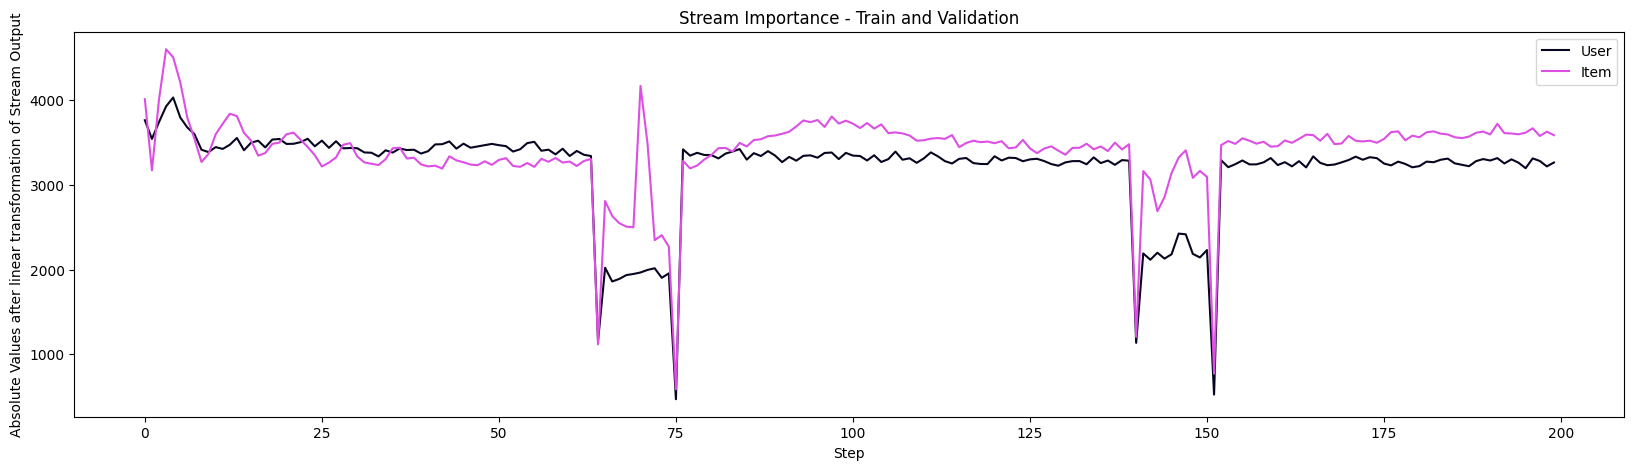

In [64]:
plt.rcParams["figure.figsize"] = (20,5)
plt.plot(x[:200], label='User', color='#070620')
plt.plot(y[:200], label='Item', color='#dd4fe4')
plt.legend()
plt.title('Stream Importance - Train and Validation')
plt.xlabel('Step')
plt.ylabel('Absolute Values after linear transformation of Stream Output')
plt.show()

##### Plot Test data

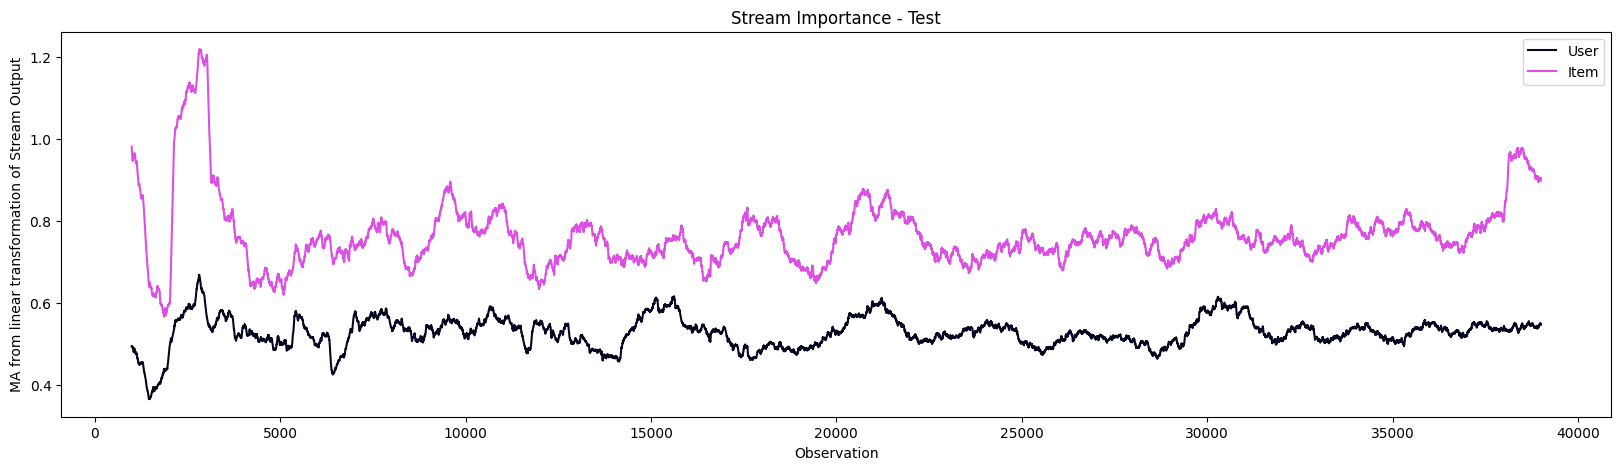

In [69]:
plt.plot(pd.Series(x[1000:40000]).rolling(1000).mean().tolist(), label='User', color='#070620')
plt.plot(pd.Series(y[1000:40000]).rolling(1000).mean().tolist(), label='Item', color='#dd4fe4')
plt.legend()
plt.title('Stream Importance - Test')
plt.xlabel('Observation')
plt.ylabel('MA from linear transformation of Stream Output')
plt.show()